# Overivew of SINDy: Sparse Identification of Nonlinear Dynamical systems

Follows [de Silva et al (2020)](https://arxiv.org/pdf/2004.08424.pdf).

See also: 
- [Brunton et al (2016)](https://www.pnas.org/content/113/15/3932)
- [de Silva et al (2019)](https://arxiv.org/pdf/1906.07906.pdf)

## Background 

Consider governing dynamical systems of the form: 

$$
\frac{d}{dt} \mathbf{x}(t) = \mathbf{f}(\mathbf{x}(t))
$$

where:
- $\mathbf{x}(t) = [x_1(t), x_2(t), ... x_n(t)]^\top \in \mathbb{R}^n$: state vector (what we observe) 
- $\mathbf{f}: \mathbb{R}^n \to \mathbb{R}^n$: function that represents the dynamic constraints that define the equation (this is what we seek to identify) 

In the SINDy approach, the dynamics in $\mathbf{f}$ are approximated with a library of candidate functions:

$$
\mathbf{f}(\mathbf{x}) \simeq \sum_{k=1}^l \theta_k(\mathbf{x}) \xi_k
$$

where the majority of the coefficients $\xi_k$ are zero. Thus, this is a sparse approximation. 


### Pose as a regression problem

To determine $\mathbf{f}$ from data, measure many instances of: $\mathbf{x}(t)$ and $\mathbf{\dot{x}} = \frac{d}{dt}\mathbf{x}$ (or approximate it with finite differences), and assemble in matrices

$$
\mathbf{X} = \left(\begin{matrix}
    x_1(t_1), & x_1(t_2), & \dots & x_1(t_n) \\
    x_2(t_1), & x_2(t_2), & \dots & x_2(t_n) \\
    \vdots, & \vdots, & \ddots & \vdots \\
    x_n(t_1), & x_n(t_2), & \dots & x_n(t_n)
\end{matrix}\right)
, \quad 
\dot{\mathbf{X}} = \left(\begin{matrix}
    \dot{x_1}(t_1), & \dot{x_1}(t_2), & \dots & \dot{x_1}(t_n) \\
    \dot{x_2}(t_1), & \dot{x_2}(t_2), & \dots & \dot{x_2}(t_n) \\
    \vdots, & \vdots, & \ddots & \vdots \\
    \dot{x_n}(t_1), & \dot{x_n}(t_2), & \dots & \dot{x_n}(t_n)
\end{matrix}\right)
$$

Then the library of candidate functions are evaluated on $\mathbf{X}$. For example

$$
\Theta(\mathbf{X}) = \left(\begin{matrix}
| & | & | & & | & | & & \\
\mathbf{1} & \mathbf{X} & \mathbf{X}^{P_2} & \dots & \sin(\mathbf{X}) & \cos(\mathbf{X}) \dots \\
| & | & | & & | & | & & 
\end{matrix}\right)
$$

where $\mathbf{X}^{P_2}$ is a matrix that captures quadratic nonlinearieits (see equation 2 in [Brunton et al (2016)](https://www.pnas.org/content/113/15/3932))

**Goal**: use sparse regression to solve

$$
\dot{\mathbf{X}} \simeq \Theta(\mathbf{X})\Xi
$$

where $\Xi$ is a set of coefficients that determines the active terms in $\mathbf{f}$

<img src="https://www.pnas.org/content/pnas/113/15/3932/F1.large.jpg?width=800&height=600&carousel=1">

**Figure 1** from [Brunton et al (2016)](https://www.pnas.org/content/113/15/3932)

In `pysindy`, each piece of the equation corresponds to a module:

- $\dot{\mathbf{X}}$:   `pysindy.differentiation`: numerical differentiation (approximate $\dot{\mathbf{X}}$ from $\mathbf{X}$)
- $\Theta(\mathbf{X})$: `pysindy.feature_library`: forming the feature library (set of functions to be considered) 
- $\Xi$:                `pysindy.optimizers`: sparse regression to estimate coefficients

## Lets do some examples! 

In [1]:
import numpy as np
from scipy.integrate import odeint
import ipywidgets
import matplotlib.pyplot as plt

import pysindy as ps

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 14

### Example 1: Lorenz system

$$
\begin{split}
\dot{x} =& \sigma(y - x)\\
\dot{y} =& x(\rho - z) - y\\
\dot{z} =& xy - \beta z
\end{split}
$$

In [3]:
def lorenz(x, t, sigma=10, rho=28, beta=8/3):
    return [
        sigma * (x[1] - x[0]), 
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    ]

In [4]:
def integrate_lorenz(lorenz_function=None, dt=0.002, tmax=10, x0=[-8, 8, 27]):
    if lorenz_function is None:
        lorenz_function = lambda x, t: lorenz(x, t)
    
    t = np.arange(0, tmax, dt)
    X = odeint(lorenz_function, x0, t)
    return X

In [5]:
dt = 0.002
X = integrate_lorenz(dt=dt)

Figure 2 from [de Silva et al (2020)](https://arxiv.org/pdf/2004.08424.pdf)

Text(0.5, 0, 'z')

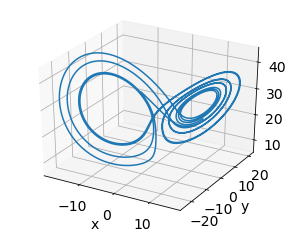

In [6]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

### Basic usage

In [7]:
model = ps.SINDy()
model.fit(X, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


In [8]:
x0_test = np.array([8, 7, 15])
tmax_test = 15
X_test = integrate_lorenz(x0=x0_test, tmax=tmax_test)

predict derivatives

In [9]:
X_dot_test_computed = model.differentiate(X_test, t=dt)
X_dot_test_predicted = model.predict(X_test)

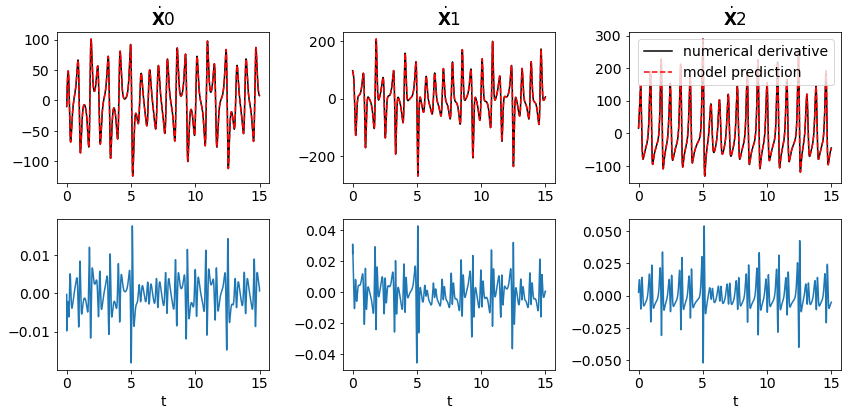

In [10]:
fig, ax=plt.subplots(2, 3, figsize=(12, 6))

t_test = np.arange(0, tmax_test, step=dt)

for i in range(3):
    ax[0, i].plot(t_test, X_dot_test_computed[:, i], 'k', label="numerical derivative")
    ax[0, i].plot(t_test, X_dot_test_predicted[:, i], '--r', label="model prediction")
    ax[0, i].set_title("$\dot{\mathbf{X}}$" + f"${i}$")
    
    ax[1, i].plot(t_test, X_dot_test_computed[:, i]-X_dot_test_predicted[:, i], label="difference")
    ax[1, i].set_xlabel("t")
ax[0, 2].legend()
plt.tight_layout()

In [11]:
X_test_sim = model.simulate(x0_test, t_test)

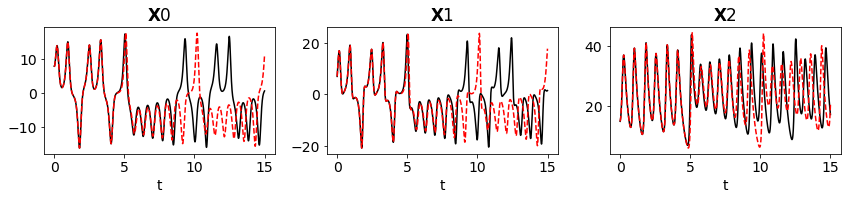

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i, a in enumerate(ax):
    a.plot(t_test, X_test[:, i], '-k')
    a.plot(t_test, X_test_sim[:, i], '--r')
    a.set_title("$\mathbf{X}$"+f"{i}")
    a.set_xlabel("t")
plt.tight_layout()